# Importação das bibliotecas

In [43]:
from scipy.stats import t
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
from scipy.stats import norm
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
from typing import List


In [19]:
def obter_intervalo_confianca(dataframe: pd.DataFrame):    
    conf_level = 0.95
    media = dataframe['preco'].mean()
    std = dataframe['preco'].std()
    n = dataframe.shape[0]
    grausLiberdade = n - 1
    t_value = t.ppf((1 + conf_level) / 2, grausLiberdade)
    inf = media - t_value * std / np.sqrt(n)
    sup = media + t_value * std / np.sqrt(n)
    print('Média:', round(media), ' Desvio padrão:', round(std))
    # Imprime o intervalo de confiança para a média
    print('Intervalo de confiança:', round(inf), '-', round(sup))

In [20]:
def obter_resumo(tipo_imovel: str, bairro: str = None, banheiro: int = None, quartos: int = None) -> pd.DataFrame:
    query = f'  tipo_imovel == "{tipo_imovel}"'
    if bairro is not None:
        query += f' and bairro_teste == "{bairro}"  '
    if banheiro is not None:
        query += f' and banheiro == {banheiro} '
    if quartos is not None:
        query += f' and quarto == {quartos} '
    base_original = pd.read_parquet('../data/processed/base_casa_v2.parquet')
    base_original = base_original.query(query)
    return base_original

In [39]:
def obter_estatistica(bairros: List[str], base_original_completa: pd.DataFrame) -> pd.DataFrame:
    lista_dados = []
    for bairro in bairros:
        dados_temp = base_original_completa.query(
            f'bairro_teste == "{bairro}"')
        lista_dados.append(
            {
                'bairro': bairro,
                'media_preco':  round(dados_temp['preco'].mean(), 2),
                'mediana_preco':  round(dados_temp['preco'].median(), 2),
                'moda': round(dados_temp['preco'].mode()[0], 2),
                'desvio_padrao': round(dados_temp['preco'].std(), 2),
                'total_imoveis': dados_temp.shape[0]
            }
        )
    df = pd.DataFrame(lista_dados)
    return df
  

- Preço Geral

In [22]:
base_original = obter_resumo(tipo_imovel='Apartamento')
base_original

,tipo_imovel,nome,preco,metragem,quarto,banheiro,garagem,ID_CASA,bairro_teste
0,Apartamento,"Apartamento com 2 Quartos à Venda, 65m²",310000.00,65,2,2,1,2699716579,Jardim Botânico
2,Apartamento,"Apartamento com 2 Quartos à Venda, 71m²",403500.00,71,2,2,2,2690493538,Bonfim Paulista
3,Apartamento,"Apartamento com 2 Quartos à Venda, 54m²",290000.00,54,2,2,1,2667652105,Nova Aliança
4,Apartamento,"Apartamento com 2 Quartos à Venda, 45m²",166420.00,45,2,1,1,2682840782,Conjunto Habitacional Jardim Das Palmeiras
5,Apartamento,"Apartamento com 2 Quartos à Venda, 64m²",370000.00,64,2,2,2,2688027260,Vila Ana Maria
...,...,...,...,...,...,...,...,...,...
9967,Apartamento,"Apartamento com 3 Quartos à Venda, 81m²",540000.00,81,3,2,2,2696267182,Vila Do Golf
9968,Apartamento,"Apartamento com Quarto à Venda, 61m²",280000.00,61,1,1,1,2476716299,Centro
9969,Apartamento,"Apartamento com 3 Quartos à Venda, 83m²",375000.00,83,3,3,2,2693112449,Jardim São Luiz
9970,Apartamento,"Apartamento com 2 Quartos à Venda, 48m²",175000.00,48,2,1,1,2572455642,Lagoinha


- Teste da normalidade de uma amostra

In [23]:
from scipy.stats import normaltest

In [24]:
base_original_completa = obter_resumo(tipo_imovel='Apartamento')
dados_sumarezinho = base_original_completa.query(
    'bairro_teste == "Sumarezinho"')
dados_centro = base_original_completa.query(
    'bairro_teste == "Centro"')

In [25]:
significancia = 0.05

In [26]:
stat_test, p_valor = normaltest(dados_sumarezinho.preco)

In [27]:
p_valor <= significancia

True

In [28]:
stat_test, p_valor = normaltest(dados_centro.preco)
p_valor <= significancia

True

- Para todos os bairros

In [29]:

import warnings
warnings.filterwarnings("ignore")

lista_dados = []
for bairro in base_original['bairro_teste'].unique():
    try:
        dados_sumarezinho = base_original_completa.query(
            f'bairro_teste == "{bairro}"')
        
        stat_test, p_valor = normaltest(dados_sumarezinho.preco)
        lista_dados.append(
            {
                'bairro': bairro,
                'teste_normalidade': p_valor <= significancia,
                'desvio_padrao': dados_sumarezinho['preco'].std(),
                'Total Imoveis': dados_sumarezinho.shape[0]
            }
                
            
        )
    except:
        pass

lista_dados = sorted(lista_dados, key=lambda x: x['desvio_padrao'])
df_teste_normalidade = pd.DataFrame(lista_dados)
df_teste_normalidade.nlargest(10, columns=['desvio_padrao'])

,bairro,teste_normalidade,desvio_padrao,Total Imoveis
99,Jardim Ilhas Do Sul,True,1752338.48,23
98,Bonfim Paulista,True,911435.88,141
97,Jardim Olhos D Agua,True,735905.38,172
96,Jardim Botânico,True,720996.16,739
95,Vila Do Golf,True,666626.96,100
94,Residencial Morro Do Ipê,True,611889.34,36
93,Jardim Canadá,True,524776.17,48
92,Bosque Das Juritis,False,443196.05,159
91,Jardim Santa Angela,False,430756.32,17
90,Ribeirânia,True,395303.50,235


In [30]:
df_teste_normalidade.nsmallest(10, columns=['desvio_padrao'])

,bairro,teste_normalidade,desvio_padrao,Total Imoveis
0,Ribeirao Verde,True,18415.75,17
1,Jardim Itaú,False,19039.14,10
2,Geraldo Correia De Carvalho,False,19094.23,13
3,Vila Abranches,True,19109.26,11
4,Jardim José Figueira,False,21737.07,10
5,Recanto Das Palmeiras,False,22612.05,8
6,Jardim Florestan Fernandes,True,24058.96,28
7,Parque Ribeirão Preto,False,24098.35,16
8,Condominío Chácara Hípica,False,25344.89,11
9,Jardim Silvio Passalacqua,False,26292.21,27


In [31]:
base_original_completa = obter_resumo(tipo_imovel='Apartamento')
dados_sumarezinho = base_original_completa.query(
    'bairro_teste == "Sumarezinho"')
dados_centro = base_original_completa.query(
    'bairro_teste == "Centro"')

<Axes: xlabel='preco', ylabel='Density'>

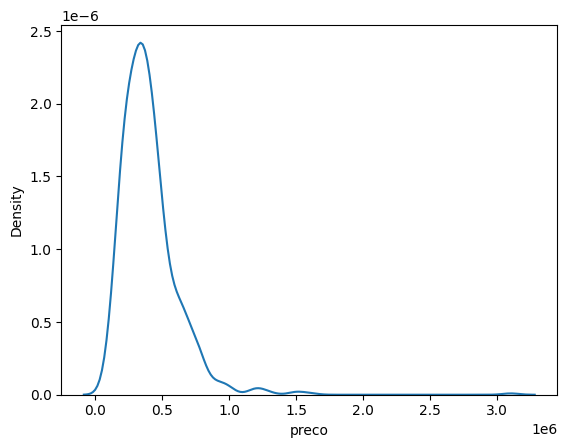

In [32]:
sns.kdeplot(dados_centro, x='preco')

<Axes: xlabel='preco', ylabel='Density'>

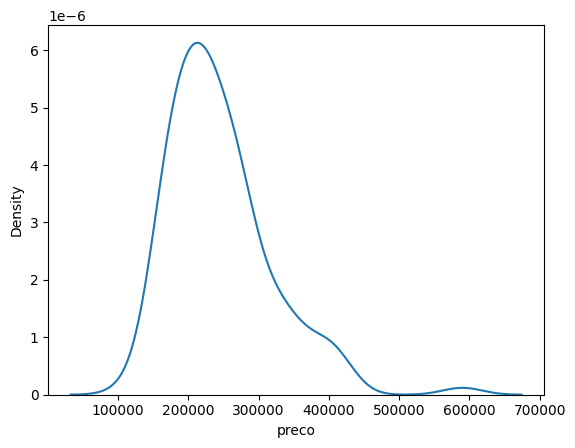

In [33]:
sns.kdeplot(dados_sumarezinho, x='preco')

In [ ]:
obter_estatistica(dados_centro)

Média preço:  402076.73
Mediana Preço: 360000.0
Moda:  450000.0
Desvio Padrão,  223344.45525125158
Total Imóveis 736


 - Teste de hipótese

<ul>
    <li>u1: Média dos imóveis do bairro sumarezinho </li>
    <li>u2: Média dos imóveis do bairro Centro </li>
    <li>H0: u1 <= u2</li>
    <li>H1: u1 > u2 XXX</li>
<ul>

In [ ]:
significancia = 0.01
confianca = 1 - significancia

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
def obter_numero_classe(dataframe: pd.DataFrame):
    n = dataframe.shape[0]


    k = 1 + (10 / 3) * np.log10(n)
    k = int(k.round(0))

    return k

<Axes: xlabel='preco', ylabel='Count'>

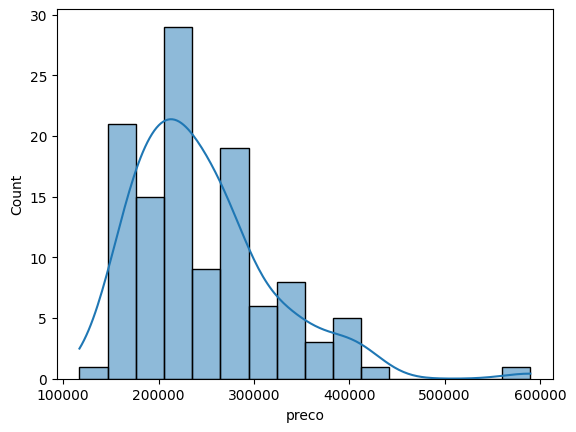

In [ ]:

k = obter_numero_classe(dados_sumarezinho)
sns.histplot(data=dados_sumarezinho, x='preco', kde=True)

<Axes: xlabel='preco', ylabel='Count'>

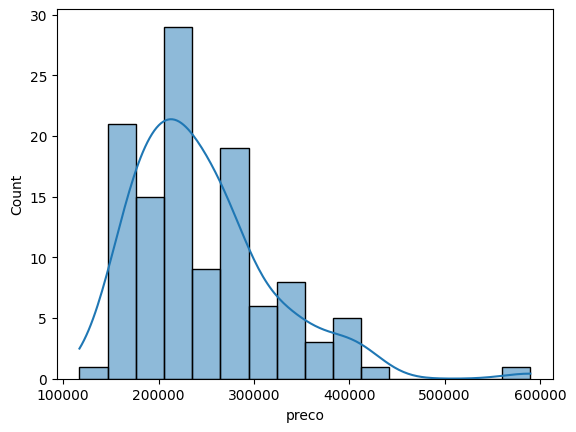

In [ ]:
sns.histplot(data=dados_sumarezinho, x='preco', kde=True)

<Axes: xlabel='preco', ylabel='Count'>

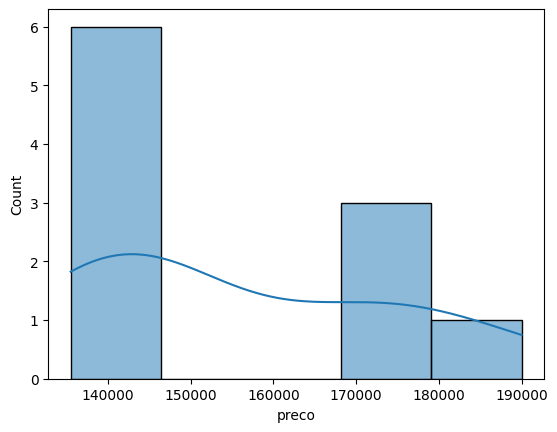

In [ ]:
k = obter_numero_classe(dados_jardim_macedo)
sns.histplot(data=dados_jardim_macedo, x='preco', kde=True)

In [ ]:
obter_estatistica(dados_jardim_macedo)

Média preço:  155900.0
Mediana Preço: 145500.0
Moda:  140000.0
Desvio Padrão,  19039.14097035076


<Axes: xlabel='preco', ylabel='Count'>

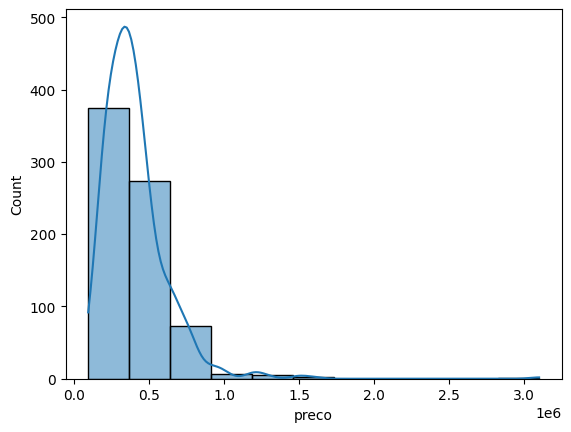

In [ ]:

k = obter_numero_classe(dados_centro)
sns.histplot(data=dados_centro, x='preco', bins=k, kde=True)

In [ ]:
obter_estatistica(dados_centro)

Média preço:  402076.73
Mediana Preço: 360000.0
Moda:  450000.0
Desvio Padrão,  223344.45525125158


In [ ]:
dados_sumarezinho = base_original_completa.query(
    'bairro_teste == "Sumarezinho"').preco
dados_centro = base_original_completa.query(
    'bairro_teste == "Centro"').preco

In [ ]:
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

In [ ]:
test_sumarezinho = DescrStatsW(dados_sumarezinho)
test_centro = DescrStatsW(dados_centro)

In [ ]:
test_a = test_sumarezinho.get_compare(test_centro)

In [ ]:
test_a.ztest_ind(alternative='larger', value=0)

(-7.546571978952292, 0.9999999999999777)

In [ ]:
z, p_valor = test_a.ztest_ind(alternative='larger', value=0)

In [ ]:
p_valor <= significancia

False

In [ ]:
test_a = CompareMeans(test_centro, test_sumarezinho)

In [ ]:
teste_b = CompareMeans(test_centro, test_sumarezinho)

-  Teste de shapiro-wilk

In [ ]:
from scipy import stats

In [ ]:
resultado = stats.shapiro(dados_sumarezinho)
resultado.pvalue

2.5383620915016895e-07

- Intervalo de confiança

In [ ]:
import numpy as np
from scipy.stats import t

conf_level = 0.95
media = dados_centro['preco'].mean()
std = dados_centro['preco'].std()
n = dados_centro.shape[0]
grausLiberdade = n - 1
t_value = t.ppf((1 + conf_level) / 2, grausLiberdade)
inf = media - t_value * std / np.sqrt(n)
sup = media + t_value * std / np.sqrt(n)
print('Média:', round(media), ' Desvio padrão:', round(std))
# Imprime o intervalo de confiança para a média
print('Intervalo de confiança:', round(inf), '-', round(sup))

Média: 402077  Desvio padrão: 223344
Intervalo de confiança: 385915 - 418239


# Análise quartos

In [ ]:
base_original_bairro = base_original_completa.query(
    'bairro_teste == "Centro"')

In [ ]:
base_original_bairro.columns

Index(['tipo_imovel', 'nome', 'preco', 'metragem', 'quarto', 'banheiro',
       'garagem', 'ID_CASA', 'bairro_teste'],
      dtype='object')

In [ ]:
base_original_bairro.quarto.value_counts()

quarto
1    103
Name: count, dtype: int64

In [ ]:
for quarto in base_original_bairro['quarto'].unique():
    print(f' {quarto} -> Quarto')
    base_temp = base_original_bairro.query(f'quarto == {quarto}')
    obter_estatistica(base_temp)
    print('=' * 20)

 3 -> Quarto
Média preço:  430715.6
Mediana Preço: 400000.0
Moda:  450000.0
Desvio Padrão,  142146.07
Total Imóveis 402
 2 -> Quarto
Média preço:  299715.14
Mediana Preço: 300000.0
Moda:  320000.0
Desvio Padrão,  85219.98
Total Imóveis 165
 1 -> Quarto
Média preço:  226877.68
Mediana Preço: 190000.0
Moda:  170000.0
Desvio Padrão,  295232.18
Total Imóveis 103
 4 -> Quarto
Média preço:  745459.38
Mediana Preço: 690000.0
Moda:  800000.0
Desvio Padrão,  271143.61
Total Imóveis 64
 5 -> Quarto
Média preço:  1125000.0
Mediana Preço: 1125000.0
Moda:  990000.0
Desvio Padrão,  190918.83
Total Imóveis 2


In [ ]:
obter_intervalo_confianca(base_original_bairro)

Média: 402077  Desvio padrão: 223344
Intervalo de confiança: 385915 - 418239


In [41]:
obter_estatistica(bairros=['Sumarezinho', 'Centro'], base_original_completa=base_original_completa)

,bairro,media_preco,mediana_preco,moda,desvio_padrao,total_imoveis
0,Sumarezinho,245524.66,230000.00,170000.00,72993.17,118
1,Centro,402076.73,360000.00,450000.00,223344.46,736
